In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/barbara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def get_unique_words(text):
    words = [word for message in text for word in message]
    return set(words)

def co_occurence_matrix_with_window(text, window_size, stop_words):
    '''
    Calculates the co-occurence matrix using a sliding window of size window_size as context    
    Output is (unique) words x (unique) words
    '''
    unique_words = get_unique_words(text)
    n = len(unique_words) #number of unique words
    co_matrix = pd.DataFrame(data=np.zeros([n,n]), columns=unique_words, index=unique_words, dtype='int')

    #for each word in each message, counts +1 for each pair [word,context]
    for message in text:
        msg_len = len(message)
        for i, word in enumerate(message):
            first = max(i - window_size, 0)
            last = min(i + window_size + 1, msg_len)
            for context in message[first:last]:
                co_matrix.loc[word,context] += 1
    return co_matrix  
    
def word_occurence_matrix(text, target=None, stop_words=None, binary=True, preprocess_text=False):  
    '''
    Output is messages x (unique) words
    
    If binary=True, then each element represents if the word is in the message or not.
    Otherwise, it represents the count of how many times that word appears in that message.
    ''' 
    if target:
        text = list(filter(lambda x : target in x, text)) #Filter comments in which target word is present
        
    preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor()   
    if stop_words:        
        stop_words = [preprocessor(word) for word in stop_words] #preprocesses stop words
    if preprocess_text:
        text = [preprocessor(msg) for msg in text] #preprocesses text
        
    #calculates word count for each message
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, binary=binary)
    X = vectorizer.fit_transform(text).toarray()
    
    labels = vectorizer.get_feature_names()
    
    return X, labels

def co_occurence_matrix(word_occurence_matrix):
    '''
    Co-occurence matrix created based on the word count/occurence matrix.     
    In other words, this co-occurence matrix will consider each message as the context for all words in it.
    '''
    co_X = word_occurence_matrix.T @ word_occurence_matrix
    np.fill_diagonal(co_X, 0)
    return co_X

def score_ngrams(text, freq_filter=1, score_metric=BigramAssocMeasures().pmi):
    '''
    Score n-grams using score_metric. Defaults to PMI.
    '''
    words = [word for msg in text for word in msg.split()]
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(freq_filter)
    return finder.score_ngrams(score_metric)

### Dados

In [4]:
comments = pd.read_csv('../../dados/youtube/comentarios1.csv')
stop_words = [word.rstrip() for word in open('../stopwords.txt')]

#Preprocesses text
preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor() #lowercase and strip accents
stop_words = [preprocessor(word) for word in stop_words]
comments['text'] = [preprocessor(msg) for msg in comments['text']]
comments['text'] = [' '.join([word for word in RegexpTokenizer(r'\w+').tokenize(msg) if not word in stop_words])
                    for msg in comments['text']]

text = comments['text'].dropna()

N = 30 #Consider only the N most frequent words

In [5]:
comments_by_channel = []
channels = []
for channel, group in comments.groupby('uploader'):
    channel_comments = group['text']
    comments_by_channel.append(channel_comments)
    channels.append(channel)

### 1. Co-ocorrência 

#### 1.1. Co-cocorrência com uma palavra pré-definida

In [6]:
target = 'ivermectina'

X, labels = word_occurence_matrix(text, target=target, stop_words=stop_words)

word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
word_count, labels, X_t = zip(*most_freq_zipped)

print(f'{N} palavras que mais ocorrem nos mesmos comentários em que "{target}" ocorre:\n')
print(list(zip(labels, word_count))[:N])

X = np.vstack(X_t).T #After unzip, X_t is (words x comments)
co_X = co_occurence_matrix(X)

30 palavras que mais ocorrem nos mesmos comentários em que "ivermectina" ocorre:

[('ivermectina', 3213), ('tomar', 650), ('dias', 631), ('covid', 585), ('dr', 444), ('dra', 441), ('pode', 431), ('pra', 376), ('uso', 370), ('azitromicina', 360), ('dia', 356), ('lucy', 345), ('tomei', 336), ('sintomas', 331), ('comprimidos', 322), ('deus', 285), ('tratamento', 284), ('todos', 275), ('medico', 274), ('pessoas', 273), ('bem', 271), ('agora', 263), ('19', 252), ('sobre', 247), ('pois', 245), ('dose', 243), ('aqui', 240), ('receita', 234), ('medicos', 234), ('protocolo', 223)]


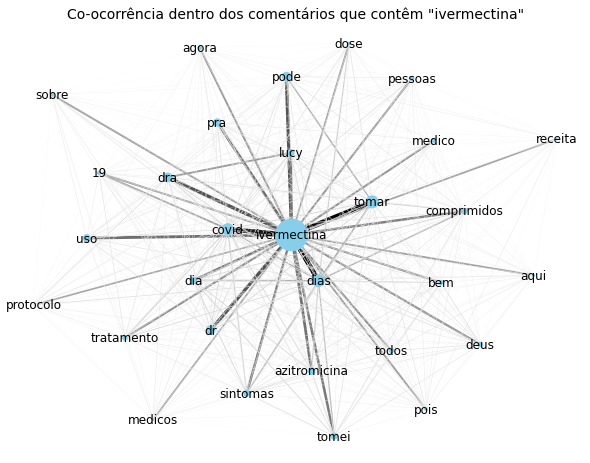

In [7]:
G = nx.Graph()

for i, row in enumerate(co_X):
    for j, co in enumerate(co_X[i]):
        G.add_edge(labels[i], labels[j], weight=(co))

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5,
        edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
        pos = nx.spring_layout(G, k=1))
plt.title(f'Co-ocorrência dentro dos comentários que contêm "{target}"', fontsize=14)
plt.show()

In [8]:
cc_by_channel = []
cc_channels = []
cc_empty = []
for i, channel in enumerate(comments_by_channel):
    try:
        X, labels = word_occurence_matrix(channel, target=target, stop_words=stop_words)
        word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
        word_count = sorted(zip(labels, word_count), reverse=True, key=lambda tupl : tupl[1])
        cc_by_channel.append(word_count)
        cc_channels.append(channels[i])
    except: #target word doesn't occur in the channel
        cc_empty.append(channels[i])
    

df_cc = pd.DataFrame(cc_by_channel, index = cc_channels).T
print(f'Nenhuma ocorrência de "{target}" nos canais: ', cc_empty)
print(f'Palavras que mais co-ocorrem nos comentários com "{target}" em cada canal:')
df_cc.head(10)

Nenhuma ocorrência de "ivermectina" nos canais:  ['Dr. Fernando Gomes']
Palavras que mais co-ocorrem nos comentários com "ivermectina" em cada canal:


,Dr. Alain Dutra,Dr. Alvaro Galvão,Dr. Felipe Ades MD PhD,Dr. Lair Ribeiro Oficial,Drauzio Varella,Julio Pereira - Neurocirurgião,Lucy Kerr
0,"(ivermectina, 1007)","(ivermectina, 312)","(deu, 3)","(ivermectina, 5)","(ivermectina, 92)","(ivermectina, 239)","(ivermectina, 1555)"
1,"(tomar, 255)","(dr, 93)","(ivermectina, 3)","(pra, 2)","(azitromicina, 31)","(azitromicina, 79)","(dra, 327)"
2,"(dias, 219)","(tomar, 80)","(19, 2)","(replicacao, 2)","(tomei, 20)","(dias, 67)","(covid, 295)"
3,"(covid, 179)","(dias, 64)","(antibiotico, 2)","(seguir, 2)","(dias, 18)","(tomei, 58)","(tomar, 273)"
4,"(dr, 163)","(covid, 59)","(boa, 2)","(tomar, 2)","(dr, 18)","(cura, 54)","(dias, 261)"
5,"(pode, 154)","(uso, 50)","(covid, 2)","(19, 1)","(covid, 15)","(https, 54)","(lucy, 248)"
6,"(pra, 118)","(pode, 48)","(dia, 2)","(48, 1)","(sintomas, 15)","(coronavirus, 52)","(pode, 211)"
7,"(uso, 110)","(alvaro, 36)","(dias, 2)","(adversos, 1)","(dia, 14)","(ajudar, 50)","(uso, 193)"
8,"(azitromicina, 106)","(19, 32)","(dor, 2)","(ai, 1)","(drauzio, 14)","(veja, 49)","(pra, 187)"
9,"(dia, 105)","(tomei, 31)","(doutor, 2)","(algum, 1)","(pra, 11)","(podera, 47)","(comprimidos, 169)"


#### 1.2. N-gramas

Considerações:

- PMI - favorece n-gramas raros. Muitos n-gramas com a mesma score (a mais alta)

#### PMI

In [9]:
pmi = BigramAssocMeasures().pmi
print(f'{N} com score mais alta:')
score_ngrams(text, score_metric=pmi, freq_filter=10)[:N]

30 com score mais alta:


[(('assalim', 'massoni'), 16.49855785890024),
 (('katti', 'assalim'), 16.49855785890024),
 (('zmnwnb8', 'ajg'), 16.49855785890024),
 (('hay', 'sama'), 16.361054335150307),
 (('1faipqlsdafkdw955ygar_0em_ndfiqcinqtyxyyliv689ylj9dfcxia', 'viewform'),
  16.361054335150303),
 (('27176561', 'drogao'), 16.361054335150303),
 (('deby', 'freiitas'), 16.361054335150303),
 (('dizzy', 'roses'), 16.361054335150303),
 (('ted', 'posseidon'), 16.361054335150303),
 (('freddy', 'yanez'), 16.23552345306645),
 (('gilselaine', 'pavan'), 16.23552345306645),
 (('hipnosisya', 'freddy'), 16.23552345306645),
 (('pavan', 'brioli'), 16.23552345306645),
 (('arn', 'sussekind'), 16.235523453066445),
 (('five', 'nights'), 16.235523453066445),
 (('reuber', 'felicio'), 16.235523453066445),
 (('park', 'jimin'), 16.120046235646512),
 (('alegrar', 'diaas'), 16.12004623564651),
 (('grow', 'rich'), 16.109992570982588),
 (('rivianne', 'ribeirohhftifi'), 16.013131031729998),
 (('gordiola', 'producoes'), 15.913595358179082),
 (

In [10]:
pmi_by_channel = []
for i, channel in enumerate(comments_by_channel):
    pmi_scores = score_ngrams(channel, score_metric=pmi, freq_filter=10)
    pmi_by_channel.append([(score[0], '%.4f'%(score[1])) for score in pmi_scores])

df_cc = pd.DataFrame(pmi_by_channel, index = channels).T
df_cc.head(10)

,Dr. Alain Dutra,Dr. Alvaro Galvão,Dr. Felipe Ades MD PhD,Dr. Fernando Gomes,Dr. Lair Ribeiro Oficial,Drauzio Varella,Julio Pereira - Neurocirurgião,Lucy Kerr
0,"((abraao, guto), 13.4266)","((youtu, be), 11.0689)","((falta, ar), 7.6377)","((deus, abencoe), 8.0056)","((aquecimento, global), 10.8000)","((https, bit), 15.0210)","((hay, sama), 14.7435)","((cel, celu), 13.8259)"
1,"((assalim, massoni), 13.4266)","((continente, africano), 10.8058)","((boa, noite), 7.5187)","((very, informative), 6.5195)","((arimathea, gomes), 10.8000)","((rivianne, ribeirohhftifi), 15.0210)","((reuber, felicio), 14.7435)","((27176561, drogao), 13.6884)"
2,"((katti, assalim), 13.4266)","((fake, news), 10.7210)","((deus, abencoe), 6.5838)","((good, work), 6.5115)","((sars, cov), 10.3935)","((dizzy, roses), 14.8835)","((roger, delgado), 14.7435)","((arn, sussekind), 13.5629)"
3,"((noemi, firmo), 13.2890)","((comprovacao, cientifica), 10.1823)","((gracas, deus), 6.5838)","((gomes, pinto), 6.2746)","((cidade, wuhan), 10.3525)","((grow, rich), 14.7580)",((1faipqlsdafkdw955ygar_0em_ndfiqcinqtyxyyliv6...,"((freddy, yanez), 13.5629)"
4,"((edielson, nogueira), 13.0480)","((ultimas, noticias), 10.0182)","((dor, cabeca), 5.8760)","((gomez, pinto), 6.1161)","((watch, v), 10.2594)","((amp, 76), 14.5356)","((deby, freiitas), 14.6060)","((gilselaine, pavan), 13.5629)"
5,"((isaac, nt), 12.9411)","((efeitos, colaterais), 9.9514)","((covid, 19), 5.8153)","((boa, noite), 6.0390)","((oleo, coco), 10.2525)","((free, fire), 14.5356)","((ted, posseidon), 14.6060)","((hipnosisya, freddy), 13.5629)"
6,"((renato, trovao), 12.5786)","((uol, br), 9.8058)","((deu, negativo), 5.6167)","((boa, tarde), 5.9105)","((youtu, be), 10.1785)","((jack, taylor), 14.5356)","((five, nights), 14.4805)","((pavan, brioli), 13.5629)"
7,"((adriana, cz), 12.5786)","((121, 150), 9.7888)","((muita, dor), 5.5992)","((thank, you), 5.9032)","((youtube, watch), 9.4129)","((gordiola, producoes), 14.4361)","((usp, sf_link), 14.4805)","((drogao, net), 13.4474)"
8,"((bonanne, vinte), 12.5786)","((2020, 07), 9.7803)","((deu, positivo), 5.2529)","((i, love), 5.5796)","((cov, 2), 9.1081)","((bit, ly), 14.3430)","((viewform, usp), 14.4805)","((cgb, tdttqxq), 13.4474)"
9,"((kkkkkkkkkkk, kkkkkkkkkkk), 12.5197)","((91, 120), 9.7444)","((14, dias), 5.1602)","((you, are), 4.9646)","((https, youtu), 8.9458)","((marcelo51, m51), 14.3430)","((park, jimin), 14.3650)","((neurociencia, felicidade), 13.4474)"


#### likelihood ratio

In [11]:
lr = BigramAssocMeasures().likelihood_ratio
print(f'{N} com score mais alta:')
score_ngrams(text, score_metric=lr, freq_filter=10)[:N]

30 com score mais alta:


[(('covid', '19'), 16892.947470233976),
 (('falta', 'ar'), 16186.704051448698),
 (('olfato', 'paladar'), 14103.109954439871),
 (('gracas', 'deus'), 12369.146510580387),
 (('dor', 'cabeca'), 11614.437174829865),
 (('deus', 'abencoe'), 11288.143898218037),
 (('youtu', 'be'), 11039.053082917235),
 (('dra', 'lucy'), 10155.46757782443),
 (('dr', 'drauzio'), 10047.217568448512),
 (('https', 'youtu'), 8958.369513217573),
 (('sentir', 'cheiro'), 8539.500821771626),
 (('15', 'dias'), 8298.801986814038),
 (('https', 'www'), 8007.512202706735),
 (('lucy', 'kerr'), 7973.473043179992),
 (('3', 'dias'), 7645.367432256628),
 (('boa', 'noite'), 6445.995892016467),
 (('cheiro', 'gosto'), 6208.185258207593),
 (('www', 'youtube'), 6153.505077922475),
 (('corona', 'virus'), 5235.015868791514),
 (('sinto', 'cheiro'), 4572.425125205145),
 (('vitamina', 'c'), 4523.5120698652),
 (('bom', 'dia'), 4473.085106279236),
 (('3', 'comprimidos'), 4406.6050363202885),
 (('lair', 'ribeiro'), 4213.562386985365),
 (('tod

In [12]:
lr_by_channel = []
for i, channel in enumerate(comments_by_channel):
    lr_scores = score_ngrams(channel, score_metric=lr, freq_filter=10)
    lr_by_channel.append([(score[0], '%.4f'%(score[1])) for score in lr_scores])

df_cc = pd.DataFrame(lr_by_channel, index = channels).T
df_cc.head(10)

,Dr. Alain Dutra,Dr. Alvaro Galvão,Dr. Felipe Ades MD PhD,Dr. Fernando Gomes,Dr. Lair Ribeiro Oficial,Drauzio Varella,Julio Pereira - Neurocirurgião,Lucy Kerr
0,"((dr, alain), 3345.1865)","((15, dias), 1433.3238)","((gracas, deus), 194.7123)","((dr, fernando), 1233.1746)","((dr, lair), 3070.5734)","((dr, drauzio), 9967.5930)","((olfato, paladar), 9285.0760)","((dra, lucy), 4949.8580)"
1,"((3, dias), 3138.7451)","((dr, alvaro), 1374.9098)","((falta, ar), 171.6449)","((boa, noite), 673.7437)","((lair, ribeiro), 1912.5059)","((falta, ar), 6662.5382)","((dor, cabeca), 7693.0153)","((youtu, be), 4866.2404)"
2,"((deus, abencoe), 2854.9078)","((alvaro, galvao), 993.0892)","((boa, noite), 139.8444)","((gomes, pinto), 466.2663)","((covid, 19), 712.1284)","((covid, 19), 4900.1746)","((falta, ar), 7523.2472)","((https, www), 4219.3319)"
3,"((dra, lucy), 2733.3967)","((dose, unica), 787.3035)","((dor, cabeca), 113.5048)","((fernando, gomes), 395.0097)","((deus, abencoe), 544.6811)","((grupo, risco), 3038.8303)","((gracas, deus), 6941.1269)","((lucy, kerr), 4011.2371)"
4,"((youtu, be), 2227.7226)","((cada, 15), 770.3126)","((covid, 19), 104.9369)","((good, work), 256.2082)","((ministro, saude), 352.3586)","((drauzio, varella), 2902.3105)","((sentir, cheiro), 6016.7352)","((https, youtu), 3718.7856)"
5,"((3, comprimidos), 2018.8471)","((covid, 19), 694.6180)","((deu, positivo), 99.8857)","((thank, you), 187.1541)","((youtu, be), 300.0899)","((bom, dia), 2835.4466)","((covid, 19), 5192.2167)","((www, youtube), 3489.6482)"
6,"((dias, seguidos), 2009.7005)","((deus, abencoe), 662.6052)","((deus, abencoe), 93.9843)","((deus, abencoe), 164.7882)","((https, youtu), 244.6088)","((99727, 3349), 2580.2149)","((cheiro, gosto), 4340.8514)","((covid, 19), 3371.1529)"
7,"((lucy, kerr), 1946.2551)","((1, comprimido), 652.6577)","((muita, dor), 89.3758)","((fernando, gomez), 101.8059)","((boa, noite), 216.2972)","((71, 99727), 2550.7629)","((sinto, cheiro), 3072.9999)","((deus, abencoe), 2826.4436)"
8,"((covid, 19), 1928.9674)","((3, comprimidos), 515.5023)","((14, dias), 86.8846)","((very, informative), 96.5598)","((https, www), 213.9909)","((todo, mundo), 2438.7842)","((youtu, be), 2687.8283)","((15, dias), 2325.5504)"
9,"((15, dias), 1918.2793)","((lucy, kerr), 498.9717)","((fiz, teste), 75.3107)","((gomez, pinto), 91.8242)","((boa, tarde), 208.9437)","((watsszzap, 71), 2176.9676)","((corona, virus), 2534.2411)","((youtube, channel), 1542.9666)"
